In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import ipywidgets
from plot_utils import get_model_names_for_degree

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [3]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

['chebyshev_linear_regression_big_2x' 'chebyshev_linear_regression_toy'
 'chebyshev_linear_regression_toy_0.2_noise'
 'chebyshev_linear_regression_toy_0.5_noise_0.00005_lr'
 'chebyshev_linear_regression_toy_11_take_1'
 'chebyshev_linear_regression_toy_16_layers'
 'chebyshev_linear_regression_toy_chebyshev_as_baseline_for_loss'
 'chebyshev_linear_regression_toy_just_base_8'
 'chebyshev_linear_regression_toy_noise'
 'chebyshev_linear_regression_toy_standard_0.00005_lr_no_noise_no_curriculum'
 'chebyshev_linear_regression_toy_uniform_sampling'
 'chebyshev_linear_regression_toy_weighted_mse' 'curriculum'
 'kernel_linear_regression_toy_basis_4'
 'kernel_linear_regression_toy_basis_4_dim_1'
 'kernel_linear_regression_toy_basis_4_normalized'
 'kernel_linear_regression_toy_basis_4_normalized_x_scale_2'
 'kernel_linear_regression_toy_dim_20_basis_2'
 'kernel_linear_regression_toy_just_basis_4_log' 'lr00005'
 'with_curriculum']
                                               run_id  \
31         

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
31,chebyshev-2x-0.0001,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_highest_de...,-1,-1,1,24,16,chebyshev_linear_regression_big_2x
0,c615f0ae-9309-49eb-a6cc-0c2680555c79,soft_prompting,chebyshev_linear_regression_toy,basis_dim=3_different_degrees=False_highest_de...,-1,-1,1,6,4,chebyshev_linear_regression_toy
25,small-0.5x-batch-64,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
27,0.25x-micro-no-noise-batch-64-basis-2-500k,kernel_linear_regression,Transformer-xs,basis_dim=2_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
29,small-0.5x-0.0005lr-1-11basis,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
33,98e97441-8b7b-42c9-ba49-c50e34f85fd8,kernel_linear_regression,Transformer-xs,basis_dim=2_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
34,c28c4728-1a7c-4b1c-a2bf-7a900b4bbb2e,kernel_linear_regression,Transformer-xs,basis_dim=1_different_degrees=False_lowest_deg...,-1,-1,1,3,2,chebyshev_linear_regression_toy
35,small-0.5x-batch-512,kernel_linear_regression,Transformer-small,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,6,4,chebyshev_linear_regression_toy
36,65c762de-027a-4019-a6e1-a8d5c07e14b7,kernel_linear_regression,Transformer-plus,basis_dim=11_different_degrees=True_lowest_deg...,-1,-1,1,24,16,chebyshev_linear_regression_toy
37,b0c94181-0a20-4b8d-899f-dada2feb1930,kernel_linear_regression,Transformer-xs,basis_dim=4_different_degrees=True_lowest_degr...,-1,-1,1,3,2,chebyshev_linear_regression_toy


In [4]:
task = "kernel_linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "soft-prompting-test-5"  # if you train more models, replace with the run_id from the table above
#run_id = "lr_00005"
run_path = os.path.join(run_dir, "soft_prompting", run_id)


run_id_big = "small-1-11-5M-steps"
run_path_big = os.path.join(run_dir, task, run_id_big)

#run_id_noise_2 = "0.25x-micro-no-noise-batch-8192-basis-1-4-500k"
#run_path_noise_2 = os.path.join(run_dir, task, run_id_noise_2) 


#run_path = '/home/riadoshi/CS182Project/models/kernel_linear_regression/cde31f7a-93a0-4aa6-b833-37e178b50ae4' # enter the path to the downloaded checkpoint here
metrics = get_run_metrics(run_path, run_path_big, None, include_noise=False, ground_truth_loss=False, smoothing=0.00)  # these are normally precomputed at the end of training


Munch({'family': 'gpt2-soft-prompt', 'n_dims': 1, 'n_embd': 128, 'n_head': 4, 'n_layer': 6, 'n_positions': 41, 'pretrained_model_dir': '../models/kernel_linear_regression/small-1-11-5M-steps', 'prompt_dim': 1})
torch.Size([1, 128])
PROMPT:  tensor([[[1.0248],
         [0.7396]]], grad_fn=<UnsafeViewBackward0>)
Orthogonal component:  tensor(4.6474, grad_fn=<CopyBackwards>)
total norm:  tensor(15.0682, grad_fn=<CopyBackwards>)
Munch({'family': 'gpt2', 'n_dims': 1, 'n_embd': 128, 'n_head': 4, 'n_layer': 6, 'n_positions': 41})
../models/soft_prompting/soft-prompting-test-4/metrics.json
no metrics found
0.2
chebyshev
cpu
torch.Size([1, 64, 40])
torch.Size([64, 40, 2])
PREDICTION SHPAPE:  torch.Size([64, 40])
chebyshev
cpu
torch.Size([1, 64, 40])
torch.Size([64, 40, 2])
PREDICTION SHPAPE:  torch.Size([64, 40])
chebyshev
cpu
torch.Size([1, 64, 40])
torch.Size([64, 40, 2])
PREDICTION SHPAPE:  torch.Size([64, 40])
chebyshev
cpu
torch.Size([1, 64, 40])
torch.Size([64, 40, 2])
PREDICTION SHPAPE: 

# Plot pre-computed metrics

../models
chebyshev_linear_regression_toy soft-prompting-test-4
Munch({'family': 'gpt2-soft-prompt', 'n_dims': 1, 'n_embd': 128, 'n_head': 4, 'n_layer': 6, 'n_positions': 41, 'pretrained_model_dir': '../models/kernel_linear_regression/small-1-11-5M-steps', 'prompt_dim': 1})
torch.Size([1, 128])
PROMPT:  tensor([[[1.0248],
         [0.7396]]], grad_fn=<UnsafeViewBackward0>)
Orthogonal component:  tensor(4.6474, grad_fn=<CopyBackwards>)
total norm:  tensor(15.0682, grad_fn=<CopyBackwards>)
../models/soft_prompting/soft-prompting-test-4/metrics.json
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
{'degree-1': {'chebyshev_1_driver=None': {'mean': [1.407156229019165, 0.4346010088920593, 2.3395682093030334e-12, 6.159505685447014e-14, 9.528494529856268e-14, 2.0263323557609923e-14, 2.0619162098751455e-14, 3.085731201265228e-14, 2.2193405018475568e-14, 7.243854225225804e-14, 1.506172641577326e-14, 3.422800169921962e-14, 1.6653941680572215e-14, 1.345349884013941e-14, 2.229853874788877e-14, 3.2590825

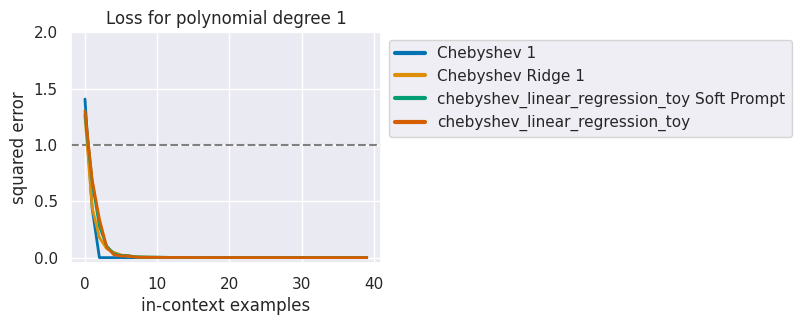

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 2', 'Chebyshev Ridge 2', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


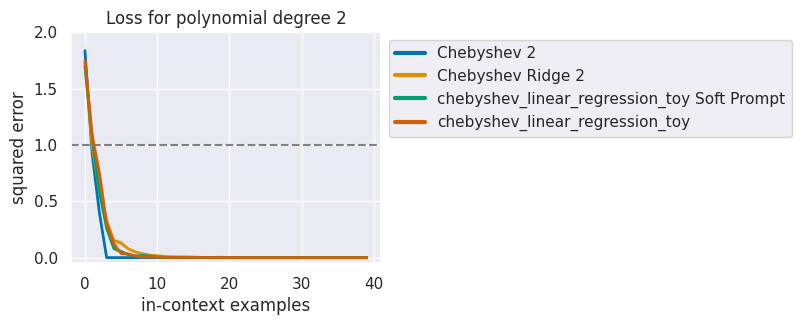

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 3', 'Chebyshev Ridge 3', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


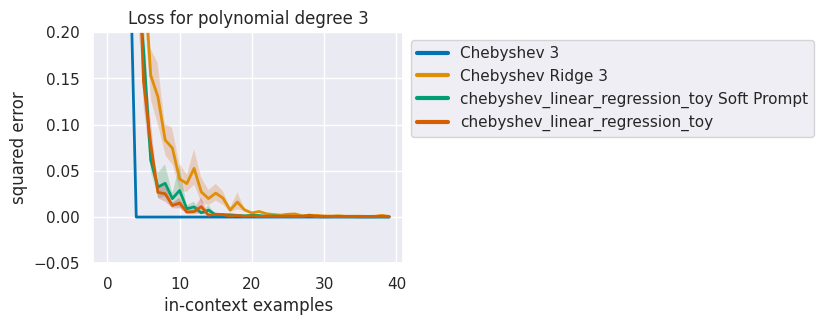

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 4', 'Chebyshev Ridge 4', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


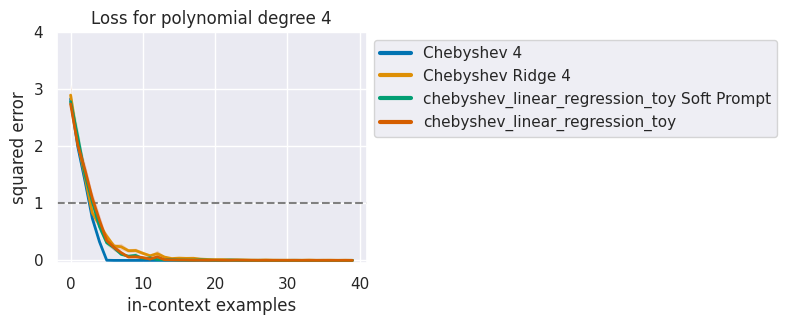

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 5', 'Chebyshev Ridge 5', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


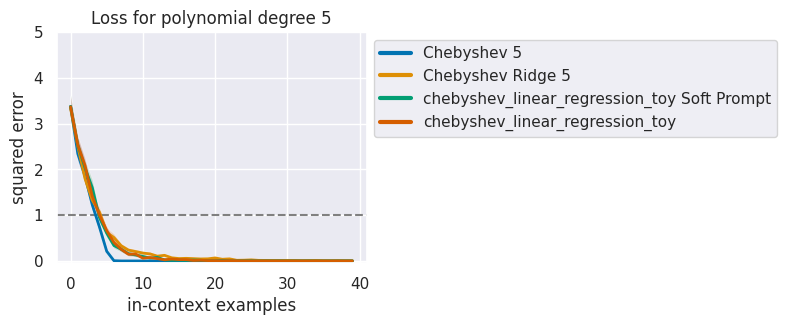

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 6', 'Chebyshev Ridge 6', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


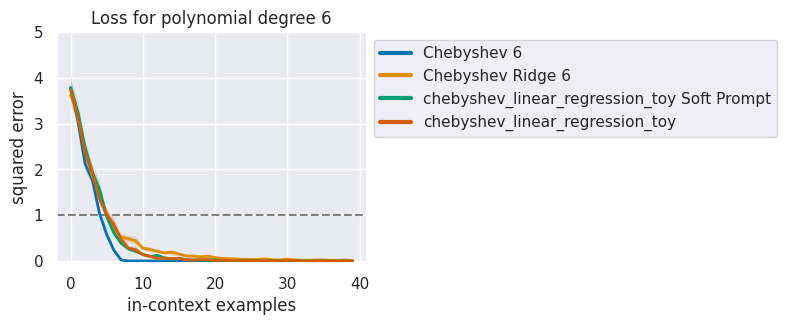

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 7', 'Chebyshev Ridge 7', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


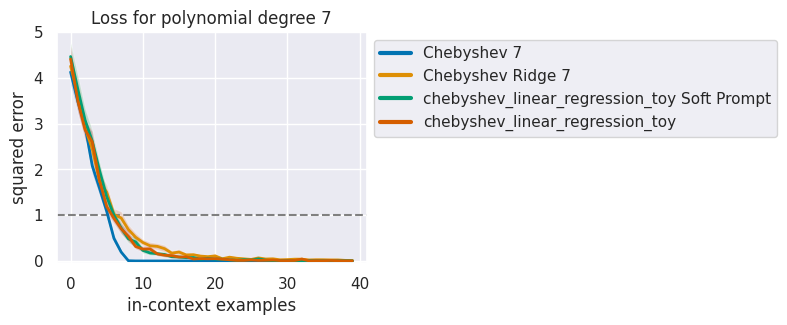

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 8', 'Chebyshev Ridge 8', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


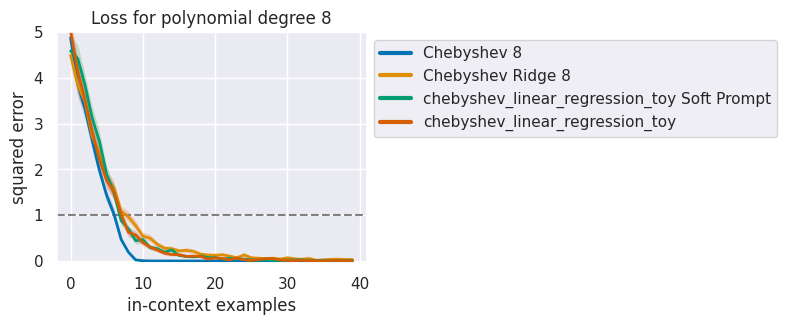

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 9', 'Chebyshev Ridge 9', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


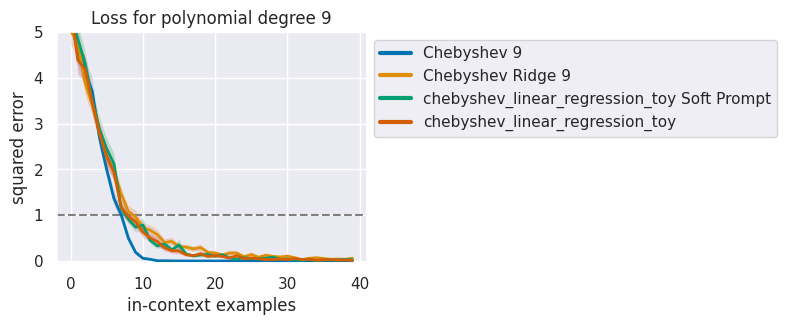

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 10', 'Chebyshev Ridge 10', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


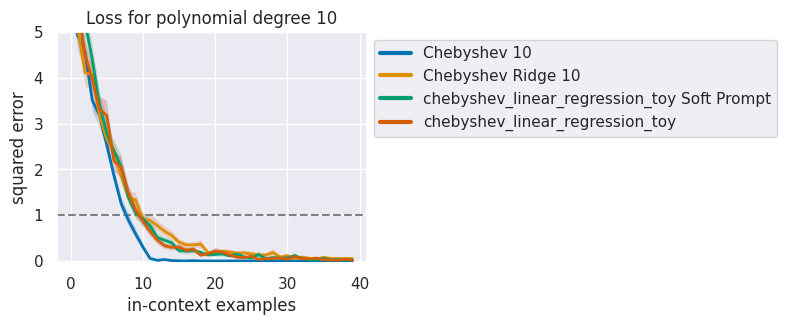

None
dict_keys(['degree-1', 'degree-10', 'degree-11', 'degree-2', 'degree-3', 'degree-4', 'degree-5', 'degree-6', 'degree-7', 'degree-8', 'degree-9'])
dict_keys(['Chebyshev 11', 'Chebyshev Ridge 11', 'chebyshev_linear_regression_toy Soft Prompt', 'chebyshev_linear_regression_toy'])


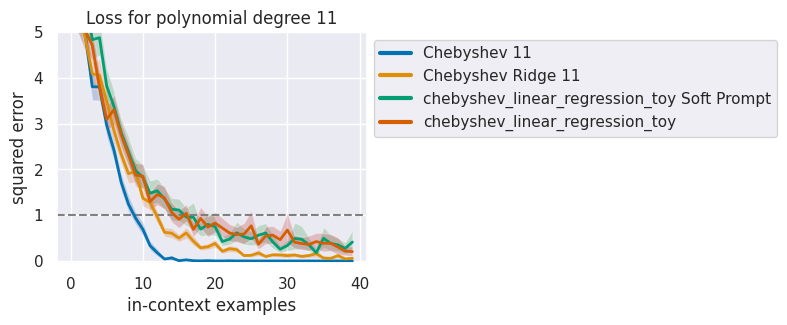

In [5]:
def valid_row(r, run_id):
    return r.task == "soft_prompting" and r.run_id == run_id

print(run_dir)
metrics = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.00)
print(metrics.keys())
print(metrics["degree-" + str(1)])
#metrics_smooth = collect_results(run_dir, df, valid_row=lambda x: valid_row(x, run_id), smoothing=0.01)
#metrics_big = collect_results(run_dir, df, valid_row= lambda x: valid_row(x, run_id_big), smoothing=0.00)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

#for k, v in metrics_big.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2] = v2
#for k, v in metrics_smooth.items():
#    for k2, v2 in v.items():
#        if "Transformer" in k2:
#            metrics[k][k2+ " Smoothed"] = v2

ylims = [2, 2, 0.2, 4, 5, 5, 5, 5, 5, 5, 5]
for degree in range(1, 12):
    models = get_model_names_for_degree(degree)
    print(models)
    print(metrics.keys())
    print(metrics["degree-" + str(degree)].keys())
    basic_plot(metrics["degree-" + str(degree)], models=models, ylim=ylims[degree-1])
    plt.title("Loss for polynomial degree " + str(degree))
    plt.savefig("graphs/degree-" + str(degree) + ".png", dpi=300, bbox_inches='tight')
    plt.show()